In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import warnings

import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix

from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import mean_squared_log_error, confusion_matrix

In [14]:
train = pd.read_csv("./resources/Consumo_cerveja.csv")
train.head()

,Data,Temperatura Media (C),Temperatura Minima (C),Temperatura Maxima (C),Precipitacao (mm),Final de Semana,Consumo de cerveja (litros)
0,2015-01-01,"27,3","23,9","32,5",0,0,25.461
1,2015-01-02,"27,02","24,5","33,5",0,0,28.972
2,2015-01-03,"24,82","22,4","29,9",0,1,30.814
3,2015-01-04,"23,98","21,5","28,6","1,2",1,29.799
4,2015-01-05,"23,82",21,"28,3",0,0,28.900


In [16]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 7 columns):
Data                           365 non-null object
Temperatura Media (C)          365 non-null object
Temperatura Minima (C)         365 non-null object
Temperatura Maxima (C)         365 non-null object
Precipitacao (mm)              365 non-null object
Final de Semana                365 non-null int64
Consumo de cerveja (litros)    365 non-null float64
dtypes: float64(1), int64(1), object(5)
memory usage: 20.0+ KB


In [17]:
train.describe()

,Final de Semana,Consumo de cerveja (litros)
count,365.000000,365.000000
mean,0.284932,25.401367
std,0.452001,4.399143
min,0.000000,14.343000
25%,0.000000,22.008000
50%,0.000000,24.867000
75%,1.000000,28.631000
max,1.000000,37.937000


In [18]:
def find_season(date):
    splitted_date = date.split('-')
    month = splitted_date[1]
    if int(month) is 12 or int(month) <= 2:
        return 'Winter'
    if int(month) <= 5:
        return 'Spring'
    if int(month) <= 8:
        return 'Summer'
    return 'Autumn'

In [19]:
find_season('2015-06-18')

'Summer'

In [20]:
train['Data'] = train['Data'].apply(lambda date : find_season(date))

In [21]:
train.head()

,Data,Temperatura Media (C),Temperatura Minima (C),Temperatura Maxima (C),Precipitacao (mm),Final de Semana,Consumo de cerveja (litros)
0,Winter,"27,3","23,9","32,5",0,0,25.461
1,Winter,"27,02","24,5","33,5",0,0,28.972
2,Winter,"24,82","22,4","29,9",0,1,30.814
3,Winter,"23,98","21,5","28,6","1,2",1,29.799
4,Winter,"23,82",21,"28,3",0,0,28.900


In [22]:
def map_to_number(df, column_name):
    df[column_name] = df[column_name].apply(lambda x : x.replace(',', '.'))
    df[column_name] = df[column_name].apply(lambda x: float(x))

In [23]:
map_to_number(train, 'Temperatura Media (C)')
map_to_number(train, 'Temperatura Minima (C)')
map_to_number(train, 'Temperatura Maxima (C)')
map_to_number(train, 'Precipitacao (mm)')

In [24]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 7 columns):
Data                           365 non-null object
Temperatura Media (C)          365 non-null float64
Temperatura Minima (C)         365 non-null float64
Temperatura Maxima (C)         365 non-null float64
Precipitacao (mm)              365 non-null float64
Final de Semana                365 non-null int64
Consumo de cerveja (litros)    365 non-null float64
dtypes: float64(5), int64(1), object(1)
memory usage: 20.0+ KB


In [25]:
numerical_vars = ['Temperatura Media (C)', 'Temperatura Minima (C)', 'Temperatura Maxima (C)', 'Precipitacao (mm)']
categorical_vars = ['Data', 'Final de Semana']

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001D870A0B5F8>,
      dtype=object)

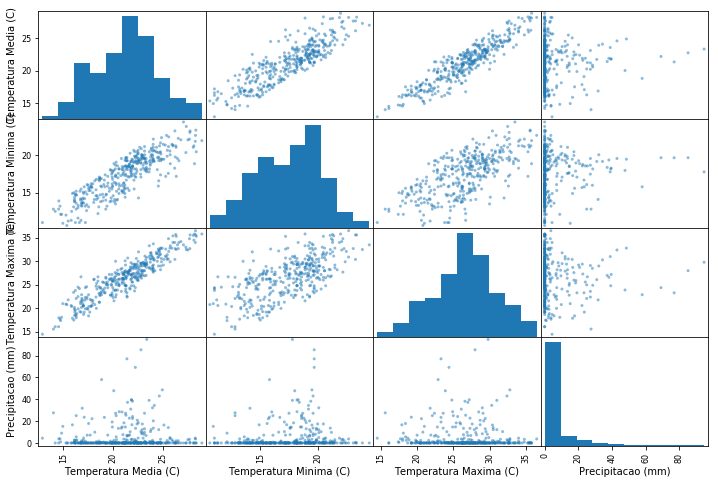

In [26]:
scatter_matrix(train[numerical_vars], figsize=(12,8))

In [28]:
class DataFrameSelector(BaseEstimator, TransformerMixin):

     def __init__(self, attribute_names):
         self.attribute_names = attribute_names

     def fit(self, X, y=None):
         return self

     def transform(self, X):
         return X[self.attribute_names].values

In [29]:
num_pipeline = Pipeline([
    ('select_numeric', DataFrameSelector(numerical_vars)),
    ('std_scaler', StandardScaler()),
])

cat_pipeline = Pipeline([
    ('select_categorical', DataFrameSelector(categorical_vars)),
    ('cat_encoder', OneHotEncoder()),
])

full_pipeline = FeatureUnion(transformer_list=[
    ('num_pipeline', num_pipeline),
    ('cat_pipeline', cat_pipeline),
])

In [30]:
train_X = train.drop(columns=['Consumo de cerveja (litros)'])
labels_X = train['Consumo de cerveja (litros)']

In [31]:
X_train_prepared = full_pipeline.fit_transform(train_X)

In [32]:
X_train, X_val, y_train, y_val = \
    train_test_split(X_train_prepared, labels_X.values, test_size=0.1, random_state=42)

In [33]:
X_train

<328x10 sparse matrix of type '<class 'numpy.float64'>'
	with 1968 stored elements in Compressed Sparse Row format>

In [35]:
param_grid = [
    {'n_estimators': [35, 40, 45, 50, 55, 60], 'max_depth': [3, 5, 7, 9]}
]

In [36]:
forest = RandomForestRegressor()
grid_search = GridSearchCV(forest, param_grid, cv=5, scoring='neg_mean_squared_log_error')
grid_search.fit(X_train, y_train)

grid_search.best_params_

{'max_depth': 5, 'n_estimators': 60}

In [37]:
best_forest = grid_search.best_estimator_

feature_importances = best_forest.feature_importances_
all_attributes = categorical_vars + numerical_vars
sorted(zip(feature_importances, all_attributes), reverse=True)

[(0.5503807032339784, 'Temperatura Media (C)'),
 (0.07597120067570604, 'Data'),
 (0.04943071559312917, 'Temperatura Minima (C)'),
 (0.02251531944757901, 'Final de Semana'),
 (0.011496734006083448, 'Temperatura Maxima (C)'),
 (0.005163948399493394, 'Precipitacao (mm)')]

In [38]:
best_forest.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=60, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [39]:
class ModelEvaluator:

    def evaluate_model(self, best_forest, input, labels, limit):
        predictions = best_forest.predict(input)
        some_predictions = predictions[:limit]
        some_labels = list(labels)[:limit]

        differences = np.array(some_predictions) - np.array(some_labels)
        relative_errors = differences / np.array(some_labels)
        rmsle = np.sqrt(mean_squared_log_error(list(labels), predictions))

        plt.plot(some_labels, label='true labels', linewidth=2)
        plt.plot(some_predictions, label='predicted labels', linewidth=2)
        plt.show()

        return relative_errors, rmsle

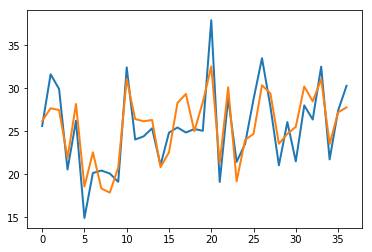

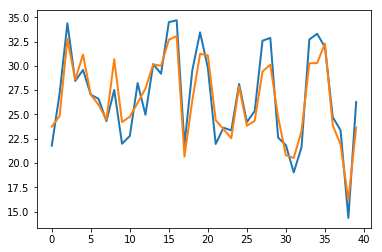

In [40]:
model_evaluator = ModelEvaluator()
relative_validation_errors, rmsle_validation = model_evaluator.evaluate_model(best_forest, X_val, y_val, 40)
relative_train_errors, rmsle_train = model_evaluator.evaluate_model(best_forest, X_train, y_train, 40)

In [41]:
rmsle_validation

0.09539895902309395

Wie oben gesehen, scheint die mittlere Tagestemperatur das eindeutig wichtigste feature zu sein. Daher versuchen wir nun ein simples lineares Modell und stellen dies unser Forest gegenüber.

In [42]:
from sklearn.linear_model import LinearRegression

In [43]:
linear_regression = LinearRegression()

In [44]:
linear_regression.fit(train['Temperatura Media (C)'].values.reshape(-1, 1), train['Consumo de cerveja (litros)'].values)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

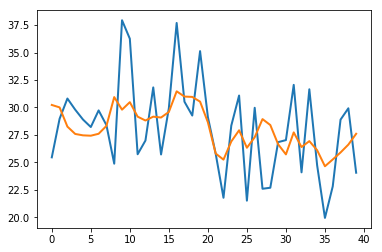

In [45]:
relative_train_errors, rmsle_train = model_evaluator.evaluate_model(linear_regression, train['Temperatura Media (C)'].values.reshape(-1, 1), train['Consumo de cerveja (litros)'].values, 40)